# Forest Tree Cover Type Classification
### Objective: Build a deep learning model to predict the forest cover type from different cartographic variables.

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from scikeras.wrappers import KerasClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Disable warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [3]:
# Load in dataset and inspect first 5 rows
forest = pd.read_csv('cover_data.csv')
forest.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
# Split data into train and test sets
X = forest.drop(columns=['class'], axis=1)
y = forest["class"] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalise data
scaler = StandardScaler()
X_train_normalised = scaler.fit_transform(X_train)
X_test_normalised = scaler.transform(X_test)

In [5]:
# --------------------------------------------------
# Build deep learning model (for RandomisedSearchCV)
# --------------------------------------------------
def build_model(n_hidden=2, n_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = keras.Sequential()
    model.add(Input(shape=(X_train_normalised.shape[1],)))
    model.add(Dense(n_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    for i in range(n_hidden - 1):
        model.add(Dense(n_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(7, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# KerasClassifier wrapper
keras_clf = KerasClassifier(
    model=build_model,
    # Switch between 50 epochs (much slower code (about 1 hour) but better final metric scores) and 20 (vice versa)
    epochs=50,
    # epochs=20,
    batch_size=1024,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=0
)


In [6]:
# --------------------------------------------------------------------------------
# Run randomised search to find best hyperparameters for optimal model performance
# --------------------------------------------------------------------------------
# Larger search space (much slower code (about 1 hour), but better final metric scores)
param_distributions = {
    'model__n_hidden': [1, 2, 3, 4],
    'model__n_units': [32, 64, 128, 256],
    'model__dropout_rate': np.linspace(0.2, 0.6, 5),
    'model__learning_rate': [1e-2, 1e-3, 1e-4],
    'batch_size': [256, 512, 1024]
}

# Smaller search space (much faster code (5-10 minutes), but lower final metric scores)
# param_distributions = {
    # 'model__n_hidden': [1, 2],
    # 'model__n_units': [32, 64],
    # 'model__dropout_rate': [0.3, 0.5],
    # 'model__learning_rate': [1e-3],
    # 'batch_size': [1024]
# }


random_search = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_distributions,
    # Switch between 20 iterations (much slower code (about 1 hour) but better final metric scores) and 5 (vice versa)
    n_iter=20,
    # n_iter=5,
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    n_jobs=1,
    verbose=2
)

random_search.fit(X_train_normalised, y_train)

print('Best hyperparameters:')
print(random_search.best_params_)

print('Best CV F1-score:')
print(random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END batch_size=512, model__dropout_rate=0.4, model__learning_rate=0.01, model__n_hidden=2, model__n_units=32; total time=  15.6s
[CV] END batch_size=512, model__dropout_rate=0.4, model__learning_rate=0.01, model__n_hidden=2, model__n_units=32; total time=   9.8s
[CV] END batch_size=512, model__dropout_rate=0.4, model__learning_rate=0.01, model__n_hidden=2, model__n_units=32; total time=  11.7s
[CV] END batch_size=512, model__dropout_rate=0.3, model__learning_rate=0.01, model__n_hidden=1, model__n_units=128; total time=  23.6s
[CV] END batch_size=512, model__dropout_rate=0.3, model__learning_rate=0.01, model__n_hidden=1, model__n_units=128; total time=  24.0s
[CV] END batch_size=512, model__dropout_rate=0.3, model__learning_rate=0.01, model__n_hidden=1, model__n_units=128; total time=  18.2s
[CV] END batch_size=256, model__dropout_rate=0.3, model__learning_rate=0.01, model__n_hidden=2, model__n_units=128; total time=  36.

Epoch 1/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6883 - loss: 0.7661 - val_accuracy: 0.7359 - val_loss: 0.6219
Epoch 2/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7305 - loss: 0.6337 - val_accuracy: 0.7511 - val_loss: 0.5824
Epoch 3/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7432 - loss: 0.6004 - val_accuracy: 0.7606 - val_loss: 0.5553
Epoch 4/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7524 - loss: 0.5761 - val_accuracy: 0.7714 - val_loss: 0.5336
Epoch 5/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7597 - loss: 0.5579 - val_accuracy: 0.7772 - val_loss: 0.5170
Epoch 6/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7661 - loss: 0.5411 - val_accuracy: 0.7853 - val_loss: 0.5024
Epoch 7/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7718 - loss: 0.5278 - val_accuracy: 0.7907 - val_loss: 0.4880
Epoch 8/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7772 - loss: 0

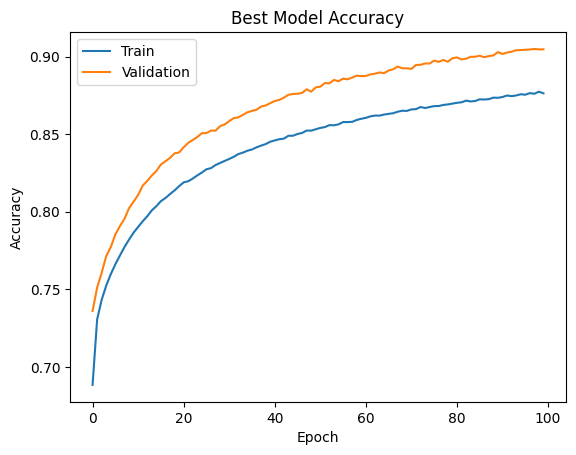

<Figure size 640x480 with 0 Axes>

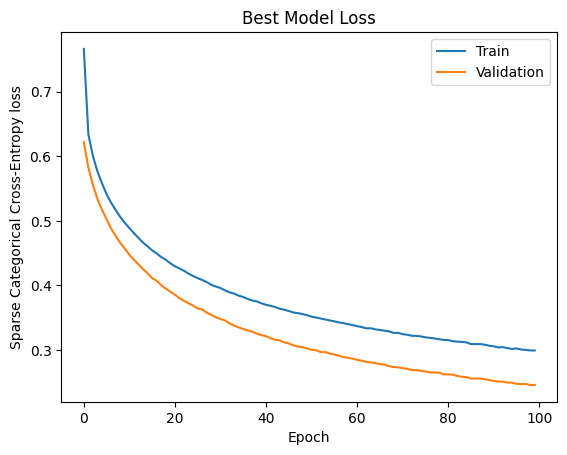

<Figure size 640x480 with 0 Axes>

In [7]:
# ----------------------------------------------------
# Build final model using best hyperparameters
# ----------------------------------------------------
best_params = random_search.best_params_

best_model = build_model(
    n_hidden=best_params['model__n_hidden'],
    n_units=best_params['model__n_units'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

# ----------------------------------------------------
# Train best model (with history for plotting)
# ----------------------------------------------------

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = best_model.fit(
    X_train_normalised,
    y_train,
    epochs=100,
    batch_size=best_params['batch_size'],
    validation_split=0.1,
    callbacks=[earlystop],
    verbose=1
)

# Plot performance per epoch
#---------------------------

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()
plt.clf()

# Loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Cross-Entropy loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.clf()


In [8]:
# -----------------------------------
# Classification report of best model 
# -----------------------------------
y_pred_probs = best_model.predict(X_test_normalised)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
print(classification_report(y_test, y_pred, target_names=class_names))
print('Weighted F1-score:', f1_score(y_test, y_pred, average='weighted'))

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 3s 800us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.91      0.88      0.90     42368
   Lodgepole Pine       0.91      0.93      0.92     56661
   Ponderosa Pine       0.90      0.91      0.90      7151
Cottonwood/Willow       0.84      0.82      0.83       549
            Aspen       0.83      0.68      0.74      1899
      Douglas-fir       0.81      0.82      0.81      3473
        Krummholz       0.92      0.92      0.92      4102

         accuracy                           0.90    116203
        macro avg       0.87      0.85      0.86    116203
     weighted avg       0.90      0.90      0.90    116203

Weighted F1-score: 0.9032524283866233


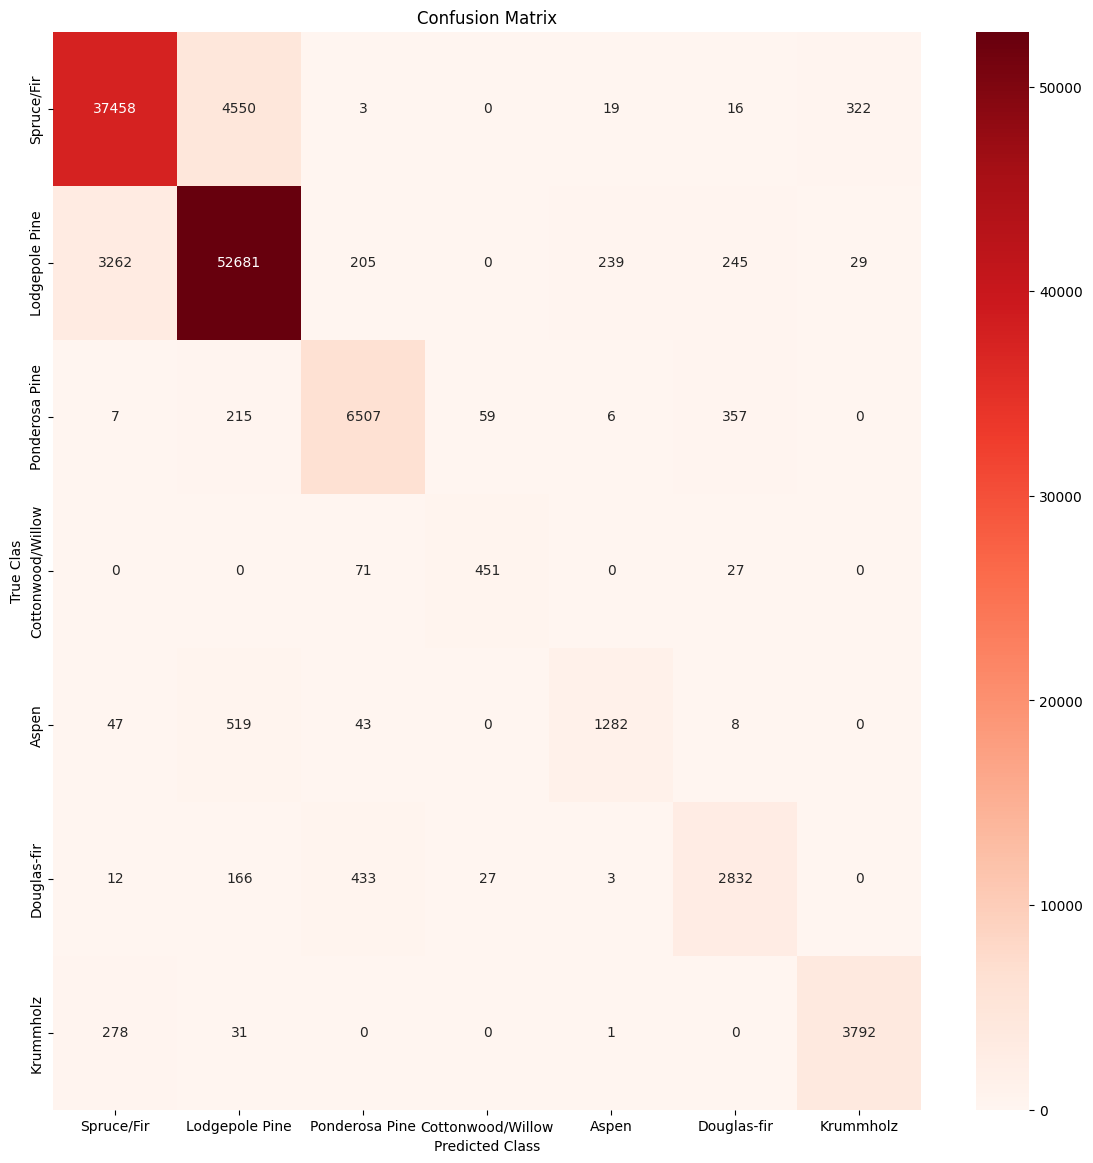

<Figure size 640x480 with 0 Axes>

In [9]:
# Create heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Clas')
plt.title('Confusion Matrix')
plt.show()
plt.clf()